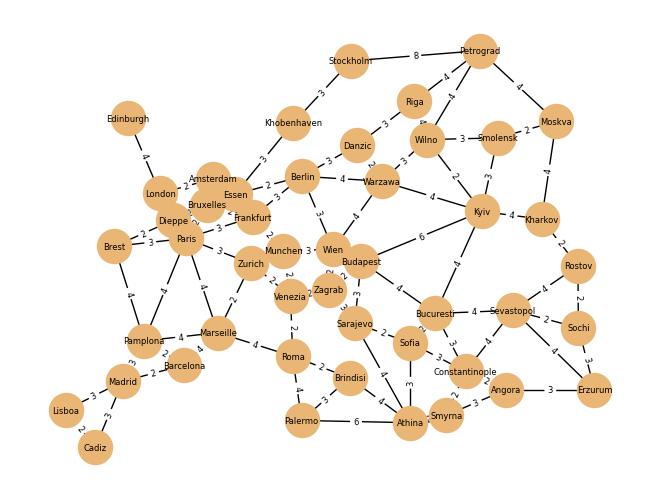

In [30]:
import networkx as nx
import pandas as pd

G = nx.Graph()

cities = pd.read_csv('cities.csv', index_col=0).to_dict(orient='index')
routes = pd.read_csv('routes.csv')
destinations = pd.read_csv('destinations.csv')

# Parcourir les lignes du DataFrame
for index, row in routes.iterrows():
    source = row['Source']
    target = row['Target']
    carriages = row['Weight']
    colored = row['Colored']
    tunnel = row['Tunnel']
    engines = row['Engine']

    G.add_edge(source, target, carriages=carriages, colored=colored, tunnel=tunnel, engines=engines)

#Show graph
positions = {city:(pos['Longitude'],pos['Latitude']) for city,pos in cities.items()}


#Affichage du graphe
nx.draw(G,positions,node_size=600,font_size = 6, node_color='#eab676',with_labels=True)

#Ecriture des poids
edge_labels = {(u, v): d['carriages'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=6,font_color='black', label_pos=0.5)

plt.show()

In [26]:
for u, v, attrs in G.edges(data=True):
    print(f'Arête entre {u} et {v}:')
    for attr, value in attrs.items():
        print(f'{attr}: {value}')
    print() 

Arête entre Lisboa et Cadiz:
carriages: 2
colored: True
tunnel: False
engines: 0

Arête entre Lisboa et Madrid:
carriages: 3
colored: True
tunnel: False
engines: 0

Arête entre Cadiz et Madrid:
carriages: 3
colored: True
tunnel: False
engines: 0

Arête entre Madrid et Pamplona:
carriages: 3
colored: True
tunnel: True
engines: 0

Arête entre Madrid et Barcelona:
carriages: 2
colored: True
tunnel: False
engines: 0

Arête entre Pamplona et Marseille:
carriages: 4
colored: True
tunnel: False
engines: 0

Arête entre Pamplona et Barcelona:
carriages: 2
colored: False
tunnel: True
engines: 0

Arête entre Pamplona et Brest:
carriages: 4
colored: True
tunnel: False
engines: 0

Arête entre Pamplona et Paris:
carriages: 4
colored: True
tunnel: False
engines: 0

Arête entre Barcelona et Marseille:
carriages: 4
colored: False
tunnel: False
engines: 0

Arête entre Marseille et Paris:
carriages: 4
colored: False
tunnel: False
engines: 0

Arête entre Marseille et Zurich:
carriages: 2
colored: False
tu

In [28]:
list(G.neighbors('Danzic'))

['Riga', 'Berlin', 'Warzawa']